In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [4]:
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [6]:
#preprocess.
from keras.preprocessing.image import ImageDataGenerator


In [7]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

In [8]:
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [9]:
import tensorflow as tf
import random as rn

In [10]:
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np         
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm 

In [11]:
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'
IMG_SIZE=100

In [12]:
def label_img(img):
    word_label = img.split('.')[0]
    return word_label

In [13]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),str(label)])
        
    shuffle(training_data)
    return training_data

In [14]:
train_data=create_train_data()
train_data=np.array(train_data)
print(train_data.shape)
X= np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y= np.array([i[1] for i in train_data])

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:58<00:00, 428.16it/s]


(25000, 2)


In [16]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img)])
        
    shuffle(testing_data)
    return testing_data

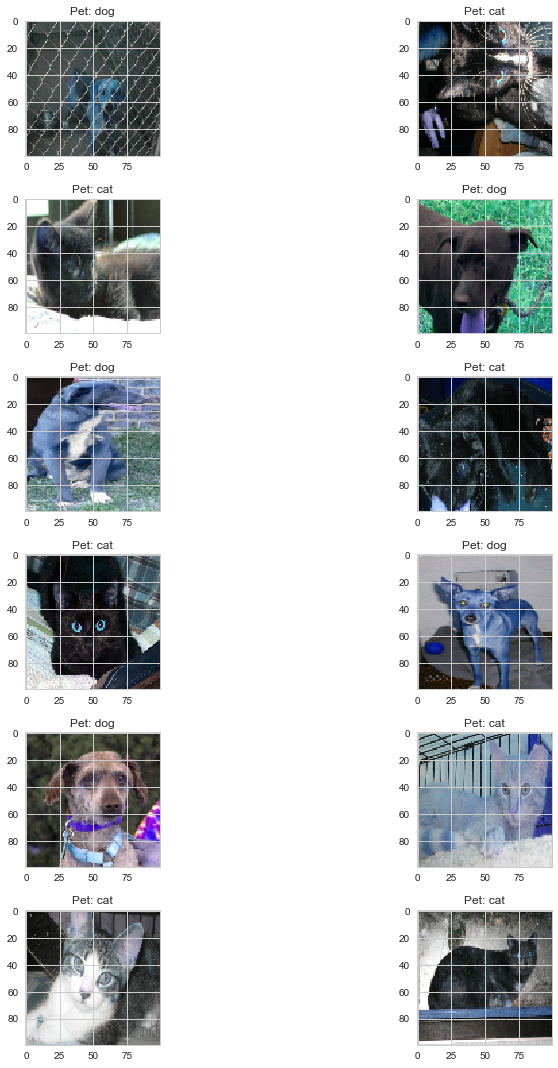

In [17]:
fig,ax=plt.subplots(6,2)
fig.set_size_inches(15,15)
for i in range(6):
    for j in range (2):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Pet: '+Y[l])
        
plt.tight_layout()

In [18]:
le=LabelEncoder()
Z=Y
Y=le.fit_transform(Y)
Y=to_categorical(Y)

NameError: name 'LabelEncoder' is not defined

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [18]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [19]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(2, activation = "sigmoid"))
 

In [20]:
batch_size=128
epochs=20

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.1)

In [21]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    horizontal_flip=True)
datagen.fit(x_train)

In [22]:
model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 96)        55392     
__________

In [24]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[red_lr])

Epoch 1/20
156/156 [==============================] - ETA: 13:46 - loss: 0.6930 - acc: 0.54 - ETA: 12:39 - loss: 2.1718 - acc: 0.49 - ETA: 12:15 - loss: 1.6790 - acc: 0.49 - ETA: 12:04 - loss: 1.4319 - acc: 0.51 - ETA: 11:54 - loss: 1.2915 - acc: 0.50 - ETA: 11:47 - loss: 1.1915 - acc: 0.50 - ETA: 11:38 - loss: 1.1204 - acc: 0.50 - ETA: 11:34 - loss: 1.0673 - acc: 0.49 - ETA: 11:30 - loss: 1.0259 - acc: 0.49 - ETA: 11:24 - loss: 0.9926 - acc: 0.49 - ETA: 11:17 - loss: 0.9654 - acc: 0.49 - ETA: 11:12 - loss: 0.9426 - acc: 0.50 - ETA: 11:05 - loss: 0.9234 - acc: 0.50 - ETA: 10:59 - loss: 0.9070 - acc: 0.50 - ETA: 10:53 - loss: 0.8928 - acc: 0.50 - ETA: 10:47 - loss: 0.8803 - acc: 0.49 - ETA: 10:42 - loss: 0.8693 - acc: 0.50 - ETA: 10:36 - loss: 0.8596 - acc: 0.49 - ETA: 10:31 - loss: 0.8509 - acc: 0.49 - ETA: 10:26 - loss: 0.8429 - acc: 0.50 - ETA: 10:21 - loss: 0.8359 - acc: 0.49 - ETA: 10:16 - loss: 0.8294 - acc: 0.49 - ETA: 10:11 - loss: 0.8236 - acc: 0.49 - ETA: 10:07 - loss: 0.8181 

156/156 [==============================] - ETA: 11:30 - loss: 0.6716 - acc: 0.57 - ETA: 7:13 - loss: 0.6647 - acc: 0.6094 - ETA: 8:35 - loss: 0.6706 - acc: 0.595 - ETA: 9:12 - loss: 0.6678 - acc: 0.593 - ETA: 9:34 - loss: 0.6705 - acc: 0.584 - ETA: 9:47 - loss: 0.6677 - acc: 0.581 - ETA: 9:58 - loss: 0.6641 - acc: 0.592 - ETA: 10:01 - loss: 0.6618 - acc: 0.59 - ETA: 10:05 - loss: 0.6618 - acc: 0.59 - ETA: 10:06 - loss: 0.6597 - acc: 0.60 - ETA: 10:07 - loss: 0.6599 - acc: 0.59 - ETA: 10:07 - loss: 0.6601 - acc: 0.60 - ETA: 10:06 - loss: 0.6581 - acc: 0.60 - ETA: 10:05 - loss: 0.6588 - acc: 0.60 - ETA: 10:05 - loss: 0.6566 - acc: 0.60 - ETA: 10:04 - loss: 0.6577 - acc: 0.60 - ETA: 10:01 - loss: 0.6586 - acc: 0.60 - ETA: 9:59 - loss: 0.6571 - acc: 0.6107 - ETA: 9:57 - loss: 0.6555 - acc: 0.614 - ETA: 9:54 - loss: 0.6544 - acc: 0.614 - ETA: 9:51 - loss: 0.6523 - acc: 0.615 - ETA: 9:47 - loss: 0.6526 - acc: 0.615 - ETA: 9:43 - loss: 0.6585 - acc: 0.610 - ETA: 9:40 - loss: 0.6584 - acc: 0.6

156/156 [==============================] - ETA: 12:12 - loss: 0.6117 - acc: 0.65 - ETA: 11:57 - loss: 0.6111 - acc: 0.65 - ETA: 11:47 - loss: 0.6012 - acc: 0.67 - ETA: 9:32 - loss: 0.6452 - acc: 0.6602 - ETA: 9:52 - loss: 0.6489 - acc: 0.636 - ETA: 10:10 - loss: 0.6425 - acc: 0.65 - ETA: 10:17 - loss: 0.6373 - acc: 0.65 - ETA: 10:26 - loss: 0.6310 - acc: 0.66 - ETA: 10:30 - loss: 0.6259 - acc: 0.66 - ETA: 10:30 - loss: 0.6248 - acc: 0.66 - ETA: 10:29 - loss: 0.6204 - acc: 0.66 - ETA: 10:27 - loss: 0.6174 - acc: 0.66 - ETA: 10:24 - loss: 0.6193 - acc: 0.66 - ETA: 10:22 - loss: 0.6185 - acc: 0.66 - ETA: 10:20 - loss: 0.6212 - acc: 0.66 - ETA: 10:17 - loss: 0.6225 - acc: 0.66 - ETA: 10:13 - loss: 0.6171 - acc: 0.66 - ETA: 10:10 - loss: 0.6184 - acc: 0.67 - ETA: 10:07 - loss: 0.6190 - acc: 0.66 - ETA: 10:03 - loss: 0.6199 - acc: 0.66 - ETA: 9:59 - loss: 0.6179 - acc: 0.6682 - ETA: 9:55 - loss: 0.6152 - acc: 0.669 - ETA: 9:51 - loss: 0.6155 - acc: 0.669 - ETA: 9:46 - loss: 0.6156 - acc: 0.6

156/156 [==============================] - ETA: 11:47 - loss: 0.5382 - acc: 0.73 - ETA: 11:52 - loss: 0.5264 - acc: 0.73 - ETA: 11:49 - loss: 0.5276 - acc: 0.73 - ETA: 11:48 - loss: 0.5277 - acc: 0.74 - ETA: 11:41 - loss: 0.5479 - acc: 0.73 - ETA: 10:09 - loss: 0.5662 - acc: 0.71 - ETA: 10:16 - loss: 0.5661 - acc: 0.72 - ETA: 10:20 - loss: 0.5559 - acc: 0.72 - ETA: 10:22 - loss: 0.5440 - acc: 0.73 - ETA: 10:22 - loss: 0.5570 - acc: 0.72 - ETA: 10:22 - loss: 0.7343 - acc: 0.71 - ETA: 10:20 - loss: 0.7220 - acc: 0.70 - ETA: 10:19 - loss: 0.7059 - acc: 0.71 - ETA: 10:17 - loss: 0.6963 - acc: 0.71 - ETA: 10:14 - loss: 0.6878 - acc: 0.70 - ETA: 10:12 - loss: 0.6796 - acc: 0.70 - ETA: 10:09 - loss: 0.6748 - acc: 0.70 - ETA: 10:05 - loss: 0.6624 - acc: 0.71 - ETA: 10:02 - loss: 0.6553 - acc: 0.71 - ETA: 9:59 - loss: 0.6483 - acc: 0.7139 - ETA: 9:55 - loss: 0.6431 - acc: 0.714 - ETA: 9:52 - loss: 0.6409 - acc: 0.714 - ETA: 9:48 - loss: 0.6362 - acc: 0.712 - ETA: 9:45 - loss: 0.6339 - acc: 0.71

156/156 [==============================] - ETA: 11:42 - loss: 0.5768 - acc: 0.71 - ETA: 11:39 - loss: 0.5096 - acc: 0.75 - ETA: 11:34 - loss: 0.4727 - acc: 0.78 - ETA: 11:30 - loss: 0.4655 - acc: 0.79 - ETA: 11:25 - loss: 0.4558 - acc: 0.78 - ETA: 11:21 - loss: 0.4470 - acc: 0.79 - ETA: 11:17 - loss: 0.4464 - acc: 0.79 - ETA: 10:10 - loss: 0.4508 - acc: 0.79 - ETA: 10:14 - loss: 0.4428 - acc: 0.79 - ETA: 10:15 - loss: 0.4394 - acc: 0.79 - ETA: 10:15 - loss: 0.4404 - acc: 0.79 - ETA: 10:15 - loss: 0.4448 - acc: 0.79 - ETA: 10:14 - loss: 0.4414 - acc: 0.79 - ETA: 10:13 - loss: 0.4411 - acc: 0.79 - ETA: 10:10 - loss: 0.4380 - acc: 0.79 - ETA: 10:08 - loss: 0.4404 - acc: 0.79 - ETA: 10:06 - loss: 0.4398 - acc: 0.79 - ETA: 10:03 - loss: 0.4398 - acc: 0.79 - ETA: 10:00 - loss: 0.4366 - acc: 0.79 - ETA: 9:57 - loss: 0.4350 - acc: 0.8006 - ETA: 9:53 - loss: 0.4299 - acc: 0.802 - ETA: 9:50 - loss: 0.4345 - acc: 0.799 - ETA: 9:46 - loss: 0.4344 - acc: 0.797 - ETA: 9:43 - loss: 0.4350 - acc: 0.79

156/156 [==============================] - ETA: 11:43 - loss: 0.3990 - acc: 0.80 - ETA: 11:33 - loss: 0.4231 - acc: 0.81 - ETA: 11:32 - loss: 0.4312 - acc: 0.81 - ETA: 11:30 - loss: 0.4164 - acc: 0.82 - ETA: 11:23 - loss: 0.4272 - acc: 0.81 - ETA: 11:17 - loss: 0.4180 - acc: 0.81 - ETA: 11:11 - loss: 0.4088 - acc: 0.82 - ETA: 11:06 - loss: 0.4017 - acc: 0.82 - ETA: 11:01 - loss: 0.3958 - acc: 0.82 - ETA: 10:08 - loss: 0.4017 - acc: 0.82 - ETA: 10:08 - loss: 0.4120 - acc: 0.81 - ETA: 10:07 - loss: 0.4083 - acc: 0.81 - ETA: 10:05 - loss: 0.4101 - acc: 0.81 - ETA: 10:03 - loss: 0.4126 - acc: 0.81 - ETA: 10:01 - loss: 0.4118 - acc: 0.81 - ETA: 9:58 - loss: 0.4104 - acc: 0.8167 - ETA: 9:55 - loss: 0.4107 - acc: 0.814 - ETA: 9:52 - loss: 0.4125 - acc: 0.811 - ETA: 9:49 - loss: 0.4145 - acc: 0.810 - ETA: 9:46 - loss: 0.4154 - acc: 0.810 - ETA: 9:43 - loss: 0.4204 - acc: 0.807 - ETA: 9:39 - loss: 0.4200 - acc: 0.807 - ETA: 9:36 - loss: 0.4212 - acc: 0.806 - ETA: 9:32 - loss: 0.4212 - acc: 0.80

156/156 [==============================] - ETA: 11:34 - loss: 0.3762 - acc: 0.83 - ETA: 11:28 - loss: 0.3494 - acc: 0.83 - ETA: 11:22 - loss: 0.3888 - acc: 0.81 - ETA: 11:19 - loss: 0.3869 - acc: 0.82 - ETA: 11:14 - loss: 0.3771 - acc: 0.83 - ETA: 11:09 - loss: 0.3800 - acc: 0.82 - ETA: 11:03 - loss: 0.3809 - acc: 0.82 - ETA: 10:59 - loss: 0.3847 - acc: 0.82 - ETA: 10:56 - loss: 0.3927 - acc: 0.81 - ETA: 10:51 - loss: 0.3928 - acc: 0.81 - ETA: 10:47 - loss: 0.3942 - acc: 0.81 - ETA: 10:02 - loss: 0.3954 - acc: 0.82 - ETA: 10:02 - loss: 0.3976 - acc: 0.81 - ETA: 10:00 - loss: 0.3944 - acc: 0.82 - ETA: 9:58 - loss: 0.3967 - acc: 0.8190 - ETA: 9:56 - loss: 0.3978 - acc: 0.817 - ETA: 9:54 - loss: 0.3959 - acc: 0.818 - ETA: 9:51 - loss: 0.3950 - acc: 0.818 - ETA: 9:48 - loss: 0.3910 - acc: 0.819 - ETA: 9:45 - loss: 0.3941 - acc: 0.818 - ETA: 9:42 - loss: 0.3934 - acc: 0.817 - ETA: 9:39 - loss: 0.3917 - acc: 0.818 - ETA: 9:35 - loss: 0.3921 - acc: 0.818 - ETA: 9:32 - loss: 0.3933 - acc: 0.81

156/156 [==============================] - ETA: 11:32 - loss: 0.3536 - acc: 0.84 - ETA: 11:27 - loss: 0.3269 - acc: 0.86 - ETA: 11:21 - loss: 0.3297 - acc: 0.87 - ETA: 11:19 - loss: 0.3602 - acc: 0.85 - ETA: 11:14 - loss: 0.3672 - acc: 0.84 - ETA: 11:09 - loss: 0.3699 - acc: 0.84 - ETA: 11:05 - loss: 0.3652 - acc: 0.84 - ETA: 11:01 - loss: 0.3625 - acc: 0.84 - ETA: 10:56 - loss: 0.3683 - acc: 0.84 - ETA: 10:52 - loss: 0.3643 - acc: 0.84 - ETA: 10:47 - loss: 0.3708 - acc: 0.84 - ETA: 10:43 - loss: 0.3740 - acc: 0.83 - ETA: 10:39 - loss: 0.3717 - acc: 0.84 - ETA: 10:01 - loss: 0.3672 - acc: 0.84 - ETA: 9:59 - loss: 0.3647 - acc: 0.8469 - ETA: 9:56 - loss: 0.3647 - acc: 0.845 - ETA: 9:54 - loss: 0.3670 - acc: 0.844 - ETA: 9:51 - loss: 0.3643 - acc: 0.846 - ETA: 9:48 - loss: 0.3642 - acc: 0.845 - ETA: 9:45 - loss: 0.3635 - acc: 0.843 - ETA: 9:41 - loss: 0.3624 - acc: 0.845 - ETA: 9:38 - loss: 0.3633 - acc: 0.845 - ETA: 9:34 - loss: 0.3657 - acc: 0.843 - ETA: 9:31 - loss: 0.3684 - acc: 0.84

156/156 [==============================] - ETA: 11:33 - loss: 0.3212 - acc: 0.86 - ETA: 11:31 - loss: 0.3700 - acc: 0.84 - ETA: 11:24 - loss: 0.3952 - acc: 0.81 - ETA: 11:18 - loss: 0.3916 - acc: 0.82 - ETA: 11:14 - loss: 0.4061 - acc: 0.81 - ETA: 11:08 - loss: 0.4012 - acc: 0.81 - ETA: 11:04 - loss: 0.3954 - acc: 0.82 - ETA: 10:59 - loss: 0.3957 - acc: 0.82 - ETA: 10:56 - loss: 0.3918 - acc: 0.82 - ETA: 10:51 - loss: 0.3855 - acc: 0.82 - ETA: 10:46 - loss: 0.3829 - acc: 0.82 - ETA: 10:42 - loss: 0.3771 - acc: 0.83 - ETA: 10:38 - loss: 0.3749 - acc: 0.83 - ETA: 10:33 - loss: 0.3762 - acc: 0.83 - ETA: 10:29 - loss: 0.3804 - acc: 0.83 - ETA: 9:56 - loss: 0.3730 - acc: 0.8369 - ETA: 9:53 - loss: 0.3721 - acc: 0.838 - ETA: 9:50 - loss: 0.3697 - acc: 0.838 - ETA: 9:47 - loss: 0.3717 - acc: 0.834 - ETA: 9:44 - loss: 0.3745 - acc: 0.834 - ETA: 9:41 - loss: 0.3773 - acc: 0.832 - ETA: 9:37 - loss: 0.3765 - acc: 0.834 - ETA: 9:34 - loss: 0.3776 - acc: 0.833 - ETA: 9:31 - loss: 0.3812 - acc: 0.83

156/156 [==============================] - ETA: 11:34 - loss: 0.4010 - acc: 0.83 - ETA: 11:29 - loss: 0.4015 - acc: 0.81 - ETA: 11:25 - loss: 0.4431 - acc: 0.78 - ETA: 11:19 - loss: 0.4225 - acc: 0.79 - ETA: 11:15 - loss: 0.4037 - acc: 0.81 - ETA: 11:12 - loss: 0.3865 - acc: 0.82 - ETA: 11:06 - loss: 0.3940 - acc: 0.82 - ETA: 11:02 - loss: 0.3904 - acc: 0.82 - ETA: 10:57 - loss: 0.3802 - acc: 0.82 - ETA: 10:52 - loss: 0.3753 - acc: 0.83 - ETA: 10:48 - loss: 0.3657 - acc: 0.83 - ETA: 10:43 - loss: 0.3650 - acc: 0.83 - ETA: 10:38 - loss: 0.3595 - acc: 0.83 - ETA: 10:34 - loss: 0.3582 - acc: 0.83 - ETA: 10:29 - loss: 0.3582 - acc: 0.83 - ETA: 10:24 - loss: 0.3570 - acc: 0.83 - ETA: 10:20 - loss: 0.3589 - acc: 0.83 - ETA: 9:50 - loss: 0.3542 - acc: 0.8385 - ETA: 9:47 - loss: 0.3585 - acc: 0.837 - ETA: 9:44 - loss: 0.3615 - acc: 0.835 - ETA: 9:41 - loss: 0.3697 - acc: 0.832 - ETA: 9:37 - loss: 0.3703 - acc: 0.831 - ETA: 9:34 - loss: 0.3695 - acc: 0.830 - ETA: 9:30 - loss: 0.3694 - acc: 0.82